In [1]:
import os
import sys

# Clone or pull part
repo_url = "https://github.com/fraco03/6D_pose.git"
repo_dir = "/content/6D_pose"
branch = "pose_rgb"

if not os.path.exists(repo_dir):
    !git clone -b {branch} {repo_url}
    print(f"Cloned {repo_url}")
else:
    %cd {repo_dir}
    !git fetch origin
    !git checkout {branch}
    !git reset --hard origin/{branch}
    %cd ..
    print(f"Updated {repo_url}")

if repo_dir not in sys.path:
    sys.path.insert(0, repo_dir)

%cd 6D_pose

Cloning into '6D_pose'...
remote: Enumerating objects: 349, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 349 (delta 1), reused 4 (delta 1), pack-reused 334 (from 1)
Receiving objects: 100% (349/349), 5.57 MiB | 29.39 MiB/s, done.
Resolving deltas: 100% (167/167), done.
Cloned https://github.com/fraco03/6D_pose.git
/content/6D_pose


In [2]:
from google.colab import drive
from utils.load_data import mount_drive

mount_drive()

dataset_root = "/content/drive/MyDrive/Linemod_preprocessed"
print(f"\n✅ Setup complete!")
print(f"📁 Dataset path: {dataset_root}")

Mounted at /content/drive
✅ Drive mounted at /content/drive

✅ Setup complete!
📁 Dataset path: /content/drive/MyDrive/Linemod_preprocessed


In [3]:
!pip install plyfile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 1.9 MB/s eta 0:00:00


In [4]:
from src.pose_rgb.pointcloud_dataset import LineModPointCloudDataset
from src.pose_rgb.pointnet_model import PointNetPose
from src.pose_rgb.loss import AutomaticWeightedLoss
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"🔥 Using device: {DEVICE}")

🔥 Using device: cuda


## Notes on the Loss Function
Difference between PointNet and RGB approach:

- RGB (ResNet + TranslationNet):

  * Predicts [dx, dy, log(z)] → then applies pinhole projection → [X, Y, Z]

  * Uses DisentangledTranslationLoss: separates XY from Z

  This makes sense because XY depend on the pinhole geometry, whereas Z is independent

- PointNet:

  * Predicts [X, Y, Z] directly from the point cloud

  * Uses a unified loss for translation: treats X, Y, and Z symmetrically

  * Since there is no pinhole projection, separating XY from Z is unnecessary

## ⚡ Performance Optimizations

**Optimizations applied to accelerate training:**

1. **Point reduction**: 1024 → 512 points per point cloud (~2x speed-up).
2. **Cached YAML files**: `linemod_config` caches `info.yml` and `gt.yml` instead of opening them for every iteration (~10-20x speed-up!).
    - **Critical on Google Drive**: I/O latency is extremely high, making caching essential.
3. **Torch sampling**: Used `torch.randperm` instead of `np.random.choice` (~1.5x speed-up).
4. **Mixed precision**: Automatic FP16/FP32 training with `torch.cuda.amp` (~1.5x speed-up).

**Estimated total speed-up: ~20-30x** compared to the initial version! 🚀

**Note**: The first batch may take longer to load and cache all YAML files; subsequent iterations will be significantly faster.

In [ ]:
# Crea dataset con point clouds
# use_rgb=True -> point cloud con 6 canali [x,y,z,r,g,b]
# use_rgb=False -> point cloud con 3 canali [x,y,z]
# preload_images=True -> carica TUTTE le immagini in RAM all'inizio (~2-3 minuti), poi il training è velocissimo

train_dataset = LineModPointCloudDataset(
    root_dir=dataset_root,
    split='train',
    num_points=512,  # Ridotto per speed-up (era 1024)
    use_rgb=True,    # Include RGB
    preload_images=True  # ⚡ CARICA TUTTO IN RAM - velociza 10x la validation!
)

test_dataset = LineModPointCloudDataset(
    root_dir=dataset_root,
    split='test',
    num_points=512,
    use_rgb=True,
    preload_images=True  # ⚡ CARICA TUTTO IN RAM
)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

✅ LineModConfig initialized: /content/drive/.shortcut-targets-by-id/1sm0RTmd3Q00Uw99X5cErD8SxrnPrGS6v/Linemod_preprocessed
📊 Loaded 2373 samples for train split
📊 Loaded 13407 samples for test split
Train samples: 2373
Test samples: 13407


## 🚀 PERFORMANCE BOOST: Image Preloading

**Bottleneck Analysis:**
- **Training (38 batch)**: 1 minuto ✅ (Già veloce grazie a YAML cache)
- **Validation (50 batch)**: Molto lento ❌ (I/O disk per ogni immagine)

**Root cause**: Ogni sample carica PNG da Google Drive (lento!) → 50 batch × 64 samples = 3200 accessi a disco

**Solution**: `preload_images=True` carica TUTTE le depth+RGB in RAM durante dataset init
- **Setup**: ~2-3 minuti la prima volta
- **Result**: Validation passa da lento a **velocissimo** (~30 secondi)
- **RAM required**: ~3-5 GB (dipende dai dati)

Set `preload_images=False` se non hai abbastanza RAM.

In [6]:
# Visualizza un sample
sample = train_dataset[0]

print("Sample keys:", sample.keys())
print(f"Point cloud shape: {sample['point_cloud'].shape}")  # (1024, 6)
print(f"Rotation shape: {sample['rotation'].shape}")        # (4,)
print(f"Translation shape: {sample['translation'].shape}")  # (3,)
print(f"\nRotation (quat): {sample['rotation']}")
print(f"Translation (m): {sample['translation']}")

Sample keys: dict_keys(['point_cloud', 'rotation', 'translation', 'object_id', 'img_id', 'cam_K', 'bbox'])
Point cloud shape: torch.Size([512, 6])
Rotation shape: (4,)
Translation shape: torch.Size([3])

Rotation (quat): [ 0.33261785  0.64730227  0.6364495  -0.2555329 ]
Translation (m): tensor([-0.1036, -0.0498,  1.0251])


In [7]:
# DataLoaders - Ottimizzati per performance
train_loader = DataLoader(
    train_dataset,
    batch_size=64,  # Aumentato da 32 per migliore GPU utilization
    shuffle=True,
    num_workers=2,  # Aumentato da 2
    pin_memory=True  # Velocizza transfer CPU->GPU
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

In [ ]:
# Import visualization utilities
from utils.projection_utils import visualize_pose_comparison
from utils.linemod_config import get_linemod_config
import matplotlib.pyplot as plt
import cv2
import numpy as np
from pathlib import Path

# Config per caricare modelli 3D
config = get_linemod_config(dataset_root)

def visualize_training_sample(model, dataset, dataset_root, checkpoint_dir, epoch, device='cuda'):
    """
    Visualizza una predizione casuale e la salva velocemente in /tmp, poi copia su Drive.
    """
    import shutil
    
    model.eval()
    
    # Sample casuale
    idx = np.random.randint(0, len(dataset))
    sample = dataset[idx]
    
    obj_id = sample['object_id']
    img_id = sample['img_id']
    
    # Carica immagine originale
    img_path = Path(dataset_root) / "data" / f"{obj_id:02d}" / "rgb" / f"{img_id:04d}.png"
    image = cv2.imread(str(img_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Prepare input
    point_cloud = sample['point_cloud'].unsqueeze(0).to(device)
    bbox_info = sample['bbox_info'].unsqueeze(0).to(device)
    
    # Inference
    with torch.no_grad():
        pred_rot, pred_trans = model(point_cloud, bbox_info)
    
    # Convert to numpy
    pred_rot = pred_rot.squeeze(0).cpu().numpy()
    pred_trans = pred_trans.squeeze(0).cpu().numpy()
    gt_rot = sample['rotation'].numpy()
    gt_trans = sample['translation'].numpy()
    cam_K = sample['cam_K'].numpy()
    
    # Visualizza
    img_vis = visualize_pose_comparison(
        image, obj_id, cam_K,
        gt_rot, gt_trans,
        pred_rot, pred_trans
    )
    
    # Calcola errori
    trans_error = np.linalg.norm(gt_trans - pred_trans)
    dot_product = np.abs(np.dot(pred_rot, gt_rot))
    dot_product = np.clip(dot_product, -1.0, 1.0)
    angle_error = 2 * np.arccos(dot_product) * 180 / np.pi
    
    # SALVA PRIMA IN /tmp (VELOCE - RAM disk)
    tmp_path = f"/tmp/vis_epoch_{epoch:03d}_obj_{obj_id:02d}.png"
    fig = plt.figure(figsize=(12, 10))
    plt.imshow(img_vis)
    plt.axis('off')
    plt.title(f"Object {obj_id} | Sample {idx} | Trans Err: {trans_error:.4f}m | Angle Err: {angle_error:.2f}°")
    plt.savefig(tmp_path, bbox_inches='tight', dpi=100)
    plt.close()
    
    # POI COPIA SU DRIVE (più lento, ma asincrono dopo)
    vis_dir = Path(checkpoint_dir) / "visualizations"
    vis_dir.mkdir(exist_ok=True)
    drive_path = vis_dir / f"epoch_{epoch:03d}_obj_{obj_id:02d}.png"
    shutil.copy(tmp_path, str(drive_path))
    
    print(f"✅ Saved: epoch {epoch} | Trans Err: {trans_error:.4f}m | Angle Err: {angle_error:.2f}°")
    
    model.train()
 
    

In [8]:
import os
import json
from datetime import datetime
from itertools import islice
import matplotlib.pyplot as plt
from torch.amp import autocast, GradScaler

# ==========================================
# HYPERPARAMETERS
# ==========================================
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50
USE_MIXED_PRECISION = True  # Mixed precision for speed-up

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
CHECKPOINT_DIR = f'/content/drive/MyDrive/runs/pointnet_{timestamp}'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Initialize PointNet Model
# input_channels=6 because we use [x,y,z,r,g,b]
model = PointNetPose(input_channels=6, use_batch_norm=True).to(DEVICE)

# Loss for PointNet
criterion = AutomaticWeightedLoss(use_disentangled=False).to(DEVICE)

# Optimizer
optimizer = torch.optim.Adam(
    list(model.parameters()) + list(criterion.parameters()),
    lr=LEARNING_RATE
)

# Mixed Precision Scaler
scaler = GradScaler('cuda') if USE_MIXED_PRECISION else None

train_losses = []
val_losses = []
best_val_loss = float('inf')
best_epoch = 0

print(f"\n🔥 STARTING POINTNET TRAINING on {DEVICE}...")
print(f"📁 Checkpoints: {CHECKPOINT_DIR}")
print(f"⚙️  Loss mode: Unified Translation (no XY/Z separation)")
print(f"⚡ Mixed Precision: {USE_MIXED_PRECISION}")


🔥 STARTING POINTNET TRAINING on cuda...
📁 Checkpoints: /content/drive/MyDrive/runs/pointnet_20251217_132025
⚙️  Loss mode: Unified Translation (no XY/Z separation)
⚡ Mixed Precision: True


In [ ]:
# ==========================================
# TRAINING LOOP (con Mixed Precision)
# ==========================================
for epoch in range(NUM_EPOCHS):

    # --- TRAIN PHASE ---
    model.train()
    running_train_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")

    for batch in pbar:
        # Move to device
        point_clouds = batch['point_cloud'].to(DEVICE, non_blocking=True)  # (B, N, 6)
        bbox_info = batch['bbox_info'].to(DEVICE, non_blocking=True)       # (B, 4)
        gt_rot = batch['rotation'].to(DEVICE, non_blocking=True)           # (B, 4)
        gt_trans = batch['translation'].to(DEVICE, non_blocking=True)      # (B, 3) in meters

        optimizer.zero_grad()

        # Mixed Precision Forward + Backward
        if USE_MIXED_PRECISION:
            with autocast('cuda'):
                pred_rot, pred_trans = model(point_clouds, bbox_info)
                loss, l_r, l_t, _ = criterion(pred_rot, gt_rot, pred_trans, gt_trans)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            pred_rot, pred_trans = model(point_clouds, bbox_info)
            loss, l_r, l_t, _ = criterion(pred_rot, gt_rot, pred_trans, gt_trans)
            loss.backward()
            optimizer.step()

        running_train_loss += loss.item()

        pbar.set_postfix({
            'L_Tot': f"{loss.item():.2f}",
            'L_Rot': f"{l_r.item():.2f}",
            'L_Trans': f"{l_t.item():.3f}"
        })

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- VALIDATION PHASE ---
    model.eval()
    running_val_loss = 0.0
    val_batches_limit = 50
    count_batches = 0

    with torch.no_grad():
        val_iterator = islice(test_loader, val_batches_limit)
        val_pbar = tqdm(val_iterator, total=val_batches_limit, desc="Validating")

        for batch in val_pbar:
            point_clouds = batch['point_cloud'].to(DEVICE, non_blocking=True)
            bbox_info = batch['bbox_info'].to(DEVICE, non_blocking=True)
            gt_rot = batch['rotation'].to(DEVICE, non_blocking=True)
            gt_trans = batch['translation'].to(DEVICE, non_blocking=True)

            if USE_MIXED_PRECISION:
                with autocast('cuda'):
                    pred_rot, pred_trans = model(point_clouds, bbox_info)
                    loss, _, _, _ = criterion(pred_rot, gt_rot, pred_trans, gt_trans)
            else:
                pred_rot, pred_trans = model(point_clouds, bbox_info)
                loss, _, _, _ = criterion(pred_rot, gt_rot, pred_trans, gt_trans)

            running_val_loss += loss.item()
            count_batches += 1

    avg_val_loss = running_val_loss / count_batches if count_batches > 0 else 0.0
    val_losses.append(avg_val_loss)

    # --- REPORT & SAVE ---
    print(f"📊 Epoch {epoch+1}: Train={avg_train_loss:.4f} | Val={avg_val_loss:.4f}")
    
    # --- VISUALIZE RANDOM SAMPLE ---
    print(f"🎨 Visualizing random validation sample...")
    visualize_training_sample(model, test_dataset, dataset_root, DEVICE)

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch + 1

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'criterion_state_dict': criterion.state_dict(),
            'val_loss': best_val_loss
        }, os.path.join(CHECKPOINT_DIR, "best_model.pth"))

        print(f"🏆 New Best Model! (Loss: {best_val_loss:.4f})")

    # Save last checkpoint
    if (epoch + 1) == NUM_EPOCHS:
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'criterion_state_dict': criterion.state_dict(),
        }, os.path.join(CHECKPOINT_DIR, f"checkpoint_ep{epoch+1}.pth"))

print("\n🎉 TRAINING COMPLETE!")

Validating: 100%|██████████| 50/50 [24:19<00:00, 29.19s/it]


📊 Epoch 1: Train=0.8885 | Val=0.2928
🏆 New Best Model! (Loss: 0.2928)


Validating: 100%|██████████| 50/50 [01:57<00:00,  2.34s/it]


📊 Epoch 2: Train=0.4411 | Val=0.2863
🏆 New Best Model! (Loss: 0.2863)


Validating: 100%|██████████| 50/50 [01:49<00:00,  2.20s/it]


📊 Epoch 3: Train=0.3790 | Val=0.2810
🏆 New Best Model! (Loss: 0.2810)


Validating: 100%|██████████| 50/50 [01:46<00:00,  2.14s/it]


📊 Epoch 4: Train=0.3558 | Val=0.2652
🏆 New Best Model! (Loss: 0.2652)


Validating: 100%|██████████| 50/50 [01:46<00:00,  2.12s/it]


📊 Epoch 5: Train=0.3371 | Val=0.2618
🏆 New Best Model! (Loss: 0.2618)


Validating: 100%|██████████| 50/50 [01:46<00:00,  2.14s/it]


📊 Epoch 6: Train=0.3254 | Val=0.2487
🏆 New Best Model! (Loss: 0.2487)


Validating: 100%|██████████| 50/50 [01:47<00:00,  2.15s/it]


📊 Epoch 7: Train=0.3222 | Val=0.2417
🏆 New Best Model! (Loss: 0.2417)


Validating: 100%|██████████| 50/50 [01:42<00:00,  2.05s/it]


📊 Epoch 8: Train=0.3177 | Val=0.2352
🏆 New Best Model! (Loss: 0.2352)


Validating: 100%|██████████| 50/50 [01:41<00:00,  2.03s/it]


📊 Epoch 9: Train=0.2984 | Val=0.2183
🏆 New Best Model! (Loss: 0.2183)


Validating: 100%|██████████| 50/50 [01:42<00:00,  2.05s/it]


📊 Epoch 10: Train=0.2823 | Val=0.2252


Validating: 100%|██████████| 50/50 [01:42<00:00,  2.05s/it]


📊 Epoch 11: Train=0.2836 | Val=0.1998
🏆 New Best Model! (Loss: 0.1998)


Validating: 100%|██████████| 50/50 [01:41<00:00,  2.02s/it]


📊 Epoch 12: Train=0.2662 | Val=0.1936
🏆 New Best Model! (Loss: 0.1936)


Validating: 100%|██████████| 50/50 [01:42<00:00,  2.06s/it]


📊 Epoch 13: Train=0.2590 | Val=0.1683
🏆 New Best Model! (Loss: 0.1683)


Validating: 100%|██████████| 50/50 [01:42<00:00,  2.05s/it]


📊 Epoch 14: Train=0.2588 | Val=0.1567
🏆 New Best Model! (Loss: 0.1567)


Validating: 100%|██████████| 50/50 [01:43<00:00,  2.08s/it]


📊 Epoch 15: Train=0.2374 | Val=0.1516
🏆 New Best Model! (Loss: 0.1516)


Validating: 100%|██████████| 50/50 [01:41<00:00,  2.03s/it]


📊 Epoch 16: Train=0.2227 | Val=0.1392
🏆 New Best Model! (Loss: 0.1392)


Validating: 100%|██████████| 50/50 [01:42<00:00,  2.05s/it]


📊 Epoch 17: Train=0.2234 | Val=0.1587


Validating: 100%|██████████| 50/50 [01:41<00:00,  2.03s/it]


📊 Epoch 18: Train=0.2004 | Val=0.1101
🏆 New Best Model! (Loss: 0.1101)


Validating: 100%|██████████| 50/50 [01:43<00:00,  2.07s/it]


📊 Epoch 19: Train=0.1921 | Val=0.0962
🏆 New Best Model! (Loss: 0.0962)


Validating: 100%|██████████| 50/50 [01:41<00:00,  2.04s/it]


📊 Epoch 20: Train=0.1838 | Val=0.0897
🏆 New Best Model! (Loss: 0.0897)


Validating: 100%|██████████| 50/50 [01:43<00:00,  2.06s/it]


📊 Epoch 21: Train=0.1674 | Val=0.0777
🏆 New Best Model! (Loss: 0.0777)


Validating: 100%|██████████| 50/50 [01:41<00:00,  2.04s/it]


📊 Epoch 22: Train=0.1499 | Val=0.1140


Validating: 100%|██████████| 50/50 [01:43<00:00,  2.07s/it]


📊 Epoch 23: Train=0.1462 | Val=0.0697
🏆 New Best Model! (Loss: 0.0697)


Validating: 100%|██████████| 50/50 [01:41<00:00,  2.04s/it]


📊 Epoch 24: Train=0.1220 | Val=0.0255
🏆 New Best Model! (Loss: 0.0255)


Validating: 100%|██████████| 50/50 [01:43<00:00,  2.07s/it]


📊 Epoch 25: Train=0.1160 | Val=0.0624


Validating: 100%|██████████| 50/50 [01:50<00:00,  2.22s/it]


📊 Epoch 26: Train=0.1065 | Val=0.0333


Epoch 27/50 [Train]:   5%|▌         | 2/38 [01:01<18:28, 30.79s/it, L_Tot=0.07, L_Rot=0.24, L_Trans=0.006]


KeyboardInterrupt: 

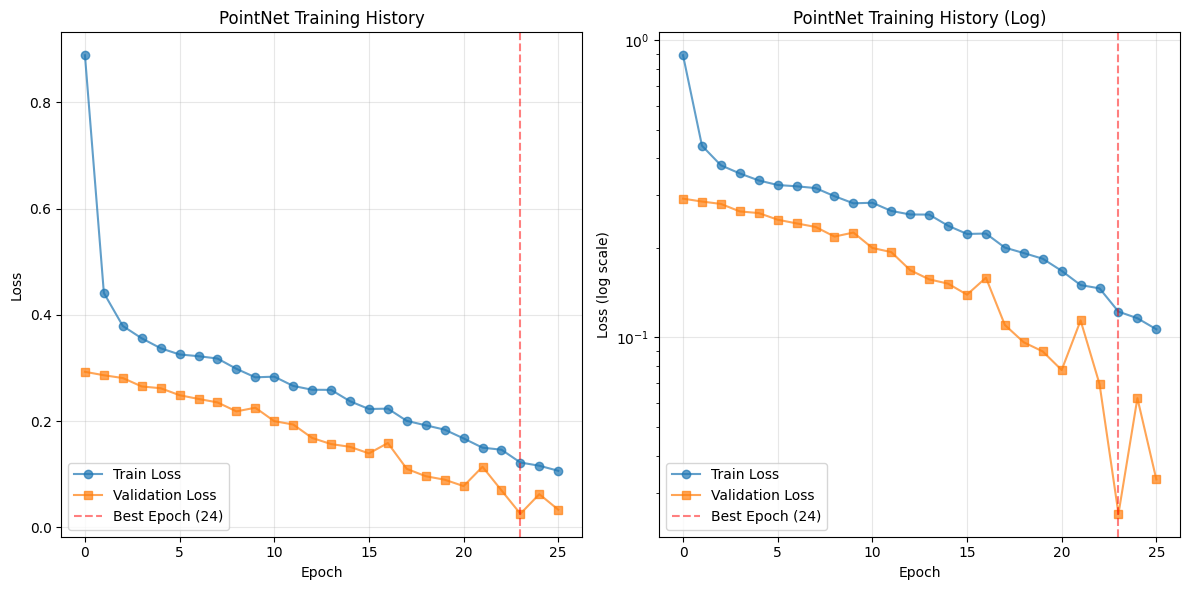


📊 Training Statistics:
   Best epoch: 24
   Best val loss: 0.025513
   Final train loss: 0.106478


In [10]:
# Plot training history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o', alpha=0.7)
plt.plot(val_losses, label='Validation Loss', marker='s', alpha=0.7)
if best_epoch > 0:
    plt.axvline(x=best_epoch-1, color='r', linestyle='--', alpha=0.5,
                label=f'Best Epoch ({best_epoch})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('PointNet Training History')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', marker='o', alpha=0.7)
plt.plot(val_losses, label='Validation Loss', marker='s', alpha=0.7)
if best_epoch > 0:
    plt.axvline(x=best_epoch-1, color='r', linestyle='--', alpha=0.5,
                label=f'Best Epoch ({best_epoch})')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.yscale('log')
plt.title('PointNet Training History (Log)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CHECKPOINT_DIR, 'training_history.png'), dpi=150)
plt.show()

print(f"\n📊 Training Statistics:")
print(f"   Best epoch: {best_epoch}")
print(f"   Best val loss: {best_val_loss:.6f}")
print(f"   Final train loss: {train_losses[-1]:.6f}")

# Save history
history = {
    'train_losses': [float(x) for x in train_losses],
    'val_losses': [float(x) for x in val_losses],
    'best_epoch': int(best_epoch),
    'best_val_loss': float(best_val_loss),
    'timestamp': timestamp
}

with open(os.path.join(CHECKPOINT_DIR, 'history.json'), 'w') as f:
    json.dump(history, f, indent=2)

## Visualize Point Cloud Sample

Visualizing point cloud from random point in the dataset

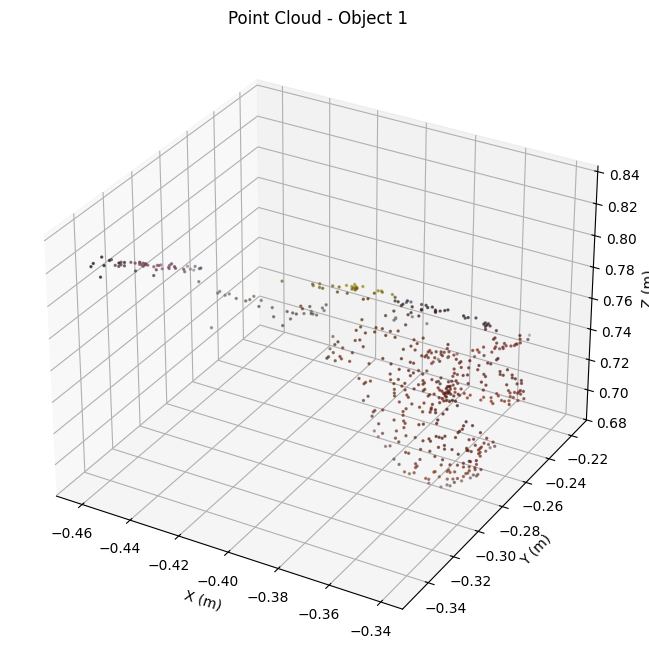

Object ID: 1
Rotation (quat): [ 0.45676994  0.8494611   0.25463983 -0.07025417]
Translation (m): tensor([-0.0339, -0.0363,  0.7203])


In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Choose sample
sample = train_dataset[100]
pc = sample['point_cloud'].numpy()  # (512, 6) [x, y, z, r, g, b]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot 3D points with RGB colors
ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2],
           c=pc[:, 3:6], s=2, alpha=0.6)

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title(f'Point Cloud - Object {sample["object_id"]}')
plt.show()

print(f"Object ID: {sample['object_id']}")
print(f"Rotation (quat): {sample['rotation']}")
print(f"Translation (m): {sample['translation']}")